In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 11.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 52.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 49.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 49.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 59.5 MB/s eta 0:00:0000:0100:01

In [2]:
import pandas as pd
import joblib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

2024-06-07 00:04:32.512993: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 00:04:32.521934: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 00:04:32.530999: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 00:04:32.590811: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 00:04:33.664100: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [3]:
#cardar datos con filtro biologico
#df= pd.read_csv("~/shared/CAMDA2024/Camda24_resistance/DataSets/SelectedVariables/ResistanceGeneCountStrictBiofiltered.tsv.gz", compression="infer", sep='\t')
df= pd.read_csv("ResistanceGeneCountStrict.tsv", sep='\t')

#separar datos a predecir
to_predict = df[df["phenotype"].isna()]

#datos para entrenar
DF_train= df[df["phenotype"].isin(["Resistant", "Susceptible"])]

In [4]:
# OTROS FILTROS

Bacteria = df["genus"].unique()
Bacterias_C = df[df["antibiotic"]=="ciprofloxacin"]["genus"].unique()
Bacterias_M = df[df["antibiotic"]=="meropenem"]["genus"].unique()

df_bacteria = {bacteria: df[df["genus"] == bacteria] for bacteria in Bacteria}
#filtrado por bacteria
to_predict_bacteria = {bacteria: to_predict[to_predict["genus"] == bacteria] for bacteria in Bacteria}

#filtrado por antibiotico
to_predict_Ciprofloxacin = to_predict[to_predict["antibiotic"]=="ciprofloxacin"]
to_predict_Meropenem = to_predict[to_predict["antibiotic"]=="meropenem"]
DF_bacteria = {bacteria: DF_train[DF_train["genus"] == bacteria] for bacteria in Bacteria}

DF_Ciprofloxacin= DF_train[DF_train["antibiotic"]=="ciprofloxacin"]
DF_Meropenem= DF_train[DF_train["antibiotic"]=="meropenem"]

## Funciones

In [5]:
def encode_labels(dataframe):
    """
    Encodes the labels in the specified column of the dataframe.
    
    Parameters:
    - dataframe: The input dataframe.
    
    Returns:
    - encoded_labels: The encoded labels.
    - label_encoder: The label encoder used for encoding.
    """
    labels = dataframe.iloc[:, 4]
    label_encoder = LabelEncoder()
    
    # Fit and transform the labels
    encoded_labels = label_encoder.fit_transform(labels)
    
    return encoded_labels, label_encoder

In [6]:
def custom_train_test_split(dataframe, labels, test_size=0.2, random_state=42):
    """
    Splits the dataframe into training and testing sets.
    
    Parameters:
    - dataframe: The input dataframe.
    - labels: The labels to be used for stratification.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Controls the shuffling applied to the data before applying the split.
    
    Returns:
    - X_train, X_test, y_train, y_test: The split datasets.
    """
    stratify_labels = labels
    
    X_train, X_test, y_train, y_test = train_test_split(
        dataframe.iloc[:, 6:],  # Splitting columns from 6 onward
        labels,
        stratify=stratify_labels,
        train_size=1 - test_size,
        random_state=random_state,
        shuffle=True
    )
    
    return X_train, X_test, y_train, y_test

In [8]:
def create_neural_network(conv_layers, filters_range, kernels_range, fc_layers, neurons_range, input_shape):
    model = models.Sequential()

    # Add convolutional layers
    for i in range(conv_layers):
        filters = filters_range[i % len(filters_range)]
        kernel_size = kernels_range[i % len(kernels_range)]
        if i == 0:
            model.add(layers.Conv2D(filters, (kernel_size, 1), activation='relu', input_shape=input_shape, padding='same'))
        else:
            model.add(layers.Conv2D(filters, (kernel_size, 1), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D(pool_size=(2, 1)))

    # Add flatten layer to transition from convolutions to fully connected layers
    model.add(layers.Flatten())

    # Add fully connected layers
    for i in range(fc_layers):
        neurons = neurons_range[i % len(neurons_range)]
        model.add(layers.Dense(neurons, activation='relu'))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [9]:
def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Evaluates the model using the test data and plots the confusion matrix.

    Parameters:
    - model: The trained model.
    - X_test: The test feature data.
    - y_test: The true labels for the test data.
    - threshold: The threshold for converting continuous predictions to binary classes.

    Returns:
    - accuracy: The accuracy of the model.
    - f1: The F1 score of the model.
    - conf_matrix: The confusion matrix.
    """
    # Predict continuous values
    y_pred_continuous = model.predict(X_test)
    
    # Convert continuous predictions to binary classes
    y_pred_binary = (y_pred_continuous >= threshold).astype(int)
    y_test_binary = (y_test >= threshold).astype(int)  # Convert true values to binary as well
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)#,normalize="true")
    #accuracy = accuracy_score(y_test_binary, y_pred_binary)
    #f1 = f1_score(y_test_binary, y_pred_binary)
    report= classification_report(y_test_binary, y_pred_binary)

    
    # Print the accuracy and F1 score
    #print(f"Accuracy: {accuracy:.2f}")
    #print(f"F1 Score: {f1:.2f}")
    print("resulados del modelo")
    print(f"{report}")

    
    
    
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
    class_labels = ["Resistant", "Susceptible"]
    
    # Create a combined annotation with raw numbers and percentages
    annot = np.empty_like(conf_matrix).astype(str)
    nrows, ncols = conf_matrix.shape
    for i in range(nrows):
        for j in range(ncols):
            annot[i, j] = f'{conf_matrix_percent[i, j]:.2f}%'
    
    # Create a new confusion matrix with percentage values
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=annot, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


    
  
    #return accuracy, f1,  report
    return report,conf_matrix
# Example usage:
# Assuming you have a trained model and test data
# accuracy, f1, conf_matrix = evaluate_model(modelo, X_test, y_test)


## Todo junto 

In [10]:
encoded_labels, label_encoder = encode_labels(DF_train)
X_train, X_test, y_train, y_test = custom_train_test_split(DF_train, encoded_labels)

In [15]:
# Ensure the correct shape
print("Original X_train shape:", X_train.shape)  # Should print (3808, 82)

# Reshape X_train and X_test to (number_of_samples, height, width, channels)
X_train_reshaped = X_train.values.reshape(-1,23, 37, 1)
X_test_reshaped = X_test.values.reshape(-1, 23, 37, 1)

# Verify the new shape
print("Reshaped X_train shape:", X_train_reshaped.shape)  # Should print (3808, 82, 1, 1)
print("Reshaped X_test shape:", X_test_reshaped.shape)  # Should print (953, 82, 1, 1)


# Example parameters
conv_layers = 3
filters_range = [32, 64, 128]
kernels_range = [3, 5, 7]  # Kernel size adjusted to fit the input shape
fc_layers = 2
neurons_range = [64, 128]
input_shape = (23, 37, 1)  # Adjusted input shape

# Create the model
model = create_neural_network(conv_layers, filters_range, kernels_range, fc_layers, neurons_range, input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print('Test accuracy:', test_acc)

Original X_train shape: (4761, 847)


ValueError: cannot reshape array of size 4032567 into shape (23,37,1)

In [ ]:
model.summary()

In [ ]:

y_pred = model.predict(X_test_reshaped)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

In [14]:
df

,accession,genus,species,antibiotic,phenotype,measurement_value,3005053,3000830,3003838,3000508,...,3001871,3006268,3005207,3001355,3001117,3001118,3001196,3001090,3001095,3002328
0,GCA_002947415,Acinetobacter,baumannii,meropenem,Resistant,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GCA_002947845,Acinetobacter,baumannii,meropenem,Resistant,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,GCA_002948925,Acinetobacter,baumannii,meropenem,Resistant,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,GCA_002996805,Acinetobacter,baumannii,meropenem,Resistant,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,GCA_003006035,Acinetobacter,baumannii,meropenem,Resistant,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7767,SRR3242343,Salmonella,enterica,ciprofloxacin,NaN,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7768,SRR2082856,Salmonella,enterica,ciprofloxacin,NaN,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7769,SRR3242362,Salmonella,enterica,ciprofloxacin,NaN,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7770,SRR1257300,Salmonella,enterica,ciprofloxacin,NaN,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Meropenem

In [ ]:
encoded_labels, label_encoder = encode_labels(DF_train)
X_train, X_test, y_train, y_test = custom_train_test_split(DF_train, encoded_labels)

X_train_reshaped = X_train.values.reshape(-1, 82, 1, 1)
X_test_reshaped = X_test.values.reshape(-1, 82, 1, 1)

model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print('Test accuracy:', test_acc)

y_pred = model.predict(X_test_reshaped)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

# Ponle pangenomas

In [34]:
import polars as pl
#Pangenomas
df_polar_M= pl.read_csv("~/shared/CAMDA2024/Camda24_resistance/DataSets/PangenomeCountMeropenem.tsv", separator="\t")

df_M = df_polar_M.to_pandas()

In [21]:
to_predict_pan_M = df_M[df_M["phenotype"].isna()]

#datos para entrenar
DF_train_pan_M= df_M[df_M["phenotype"].isin(["Resistant", "Susceptible"])]

NameError: name 'df_M' is not defined

In [38]:
encoded_labels_M, label_encoder_M = encode_labels(DF_train_pan_M)
X_train_M, X_test_M, y_train_M, y_test_M = custom_train_test_split(DF_train_pan_M, encoded_labels_M)

In [41]:
X_train_M.shape

(2507, 217857)

In [42]:
model_M = create_neural_network(conv_layers, filters_range, kernels_range, fc_layers, neurons_range, input_shape)

# Compile the model
model_M.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [20]:
new_shape_product = 461 * 473

# Pad data to fit the shape
height = 471
width = 463

input_shape = (height, width, 1)

# Calculate the padding needed
new_shape_product = height * width
padding_needed = new_shape_product - X_train_M.shape[1]

# Pad data to fit the shape
X_train_padded_M = np.pad(X_train_M.values, [(0, 0), (0, padding_needed)], mode='constant')
X_test_padded_M = np.pad(X_test_M.values, [(0, 0), (0, padding_needed)], mode='constant')

# Reshape X_train and X_test to (number_of_samples, height, width, channels)
X_train_reshaped_M = X_train_padded_M.reshape(-1, height, width, 1)
X_test_reshaped_M = X_test_padded_M.reshape(-1, height, width, 1)

model_M.fit(X_train_reshaped_M, y_train_M, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss_M, test_acc_M = model_M.evaluate(X_test_reshaped_M, y_test_M)
print('Test accuracy:', test_acc_M)

y_pred_M = model_M.predict(X_test_reshaped_M)
y_pred_M = (y_pred_M > 0.5)  # Convert probabilities to binary predictions

# Generate classification report
report_M = classification_report(y_test_M, y_pred_M)
print(report_M)

NameError: name 'X_train_M' is not defined

In [11]:

print("Original X_train shape:", X_train.shape)  # Should print (4761, 847)

# Calculate the dimensions for reshaping
height = 29
width = 30

# Calculate the padding needed
new_shape_product = height * width
padding_needed = new_shape_product - X_train.shape[1]

# Pad data to fit the shape
X_train_padded = np.pad(X_train.values, [(0, 0), (0, padding_needed)], mode='constant')
X_test_padded = np.pad(X_test.values, [(0, 0), (0, padding_needed)], mode='constant')

# Reshape X_train and X_test to (number_of_samples, height, width, channels)
X_train_reshaped = X_train_padded.reshape(-1, height, width, 1)
X_test_reshaped = X_test_padded.reshape(-1, height, width, 1)

# Verify the new shape
print("Reshaped X_train shape:", X_train_reshaped.shape)  # Should print (4761, 29, 30, 1)
print("Reshaped X_test shape:", X_test_reshaped.shape)  # Should print (1191, 29, 30, 1)

# Define the neural network
def create_neural_network(conv_layers, filters_range, kernels_range, fc_layers, neurons_range, input_shape):
    model = models.Sequential()

    # Add convolutional layers
    for i in range(conv_layers):
        filters = filters_range[i % len(filters_range)]
        kernel_size = kernels_range[i % len(kernels_range)]
        if i == 0:
            model.add(layers.Conv2D(filters, (kernel_size, kernel_size), activation='relu', input_shape=input_shape, padding='same'))
        else:
            model.add(layers.Conv2D(filters, (kernel_size, kernel_size), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Add flatten layer to transition from convolutions to fully connected layers
    model.add(layers.Flatten())

    # Add fully connected layers
    for i in range(fc_layers):
        neurons = neurons_range[i % len(neurons_range)]
        model.add(layers.Dense(neurons, activation='relu'))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Example parameters
conv_layers = 3
filters_range = [32, 64, 128]
kernels_range = [3, 5, 7]
fc_layers = 2
neurons_range = [64, 128]
input_shape = (height, width, 1)  # Adjusted input shape

# Create the model
model = create_neural_network(conv_layers, filters_range, kernels_range, fc_layers, neurons_range, input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print('Test accuracy:', test_acc)


Original X_train shape: (4761, 847)
Reshaped X_train shape: (4761, 29, 30, 1)
Reshaped X_test shape: (1191, 29, 30, 1)


2024-06-07 00:08:33.988057: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7895 - loss: 0.4354 - val_accuracy: 0.8930 - val_loss: 0.2487
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9036 - loss: 0.2352 - val_accuracy: 0.9244 - val_loss: 0.2077
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9298 - loss: 0.1859 - val_accuracy: 0.9108 - val_loss: 0.2071
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9359 - loss: 0.1709 - val_accuracy: 0.9423 - val_loss: 0.1753
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9428 - loss: 0.1518 - val_accuracy: 0.9391 - val_loss: 0.1805
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9509 - loss: 0.1341 - val_accuracy: 0.9349 - val_loss: 0.1871
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9588 - loss: 0.1175 - val_accuracy: 0.9402 - val_loss: 0.1637
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9625 - loss: 0.1072 - val_accu

In [12]:

y_pred = model.predict(X_test_reshaped)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       276
           1       0.96      0.97      0.96       915

    accuracy                           0.94      1191
   macro avg       0.92      0.91      0.92      1191
weighted avg       0.94      0.94      0.94      1191



38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
resulados del modelo
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       276
           1       0.96      0.97      0.96       915

    accuracy                           0.94      1191
   macro avg       0.92      0.91      0.92      1191
weighted avg       0.94      0.94      0.94      1191



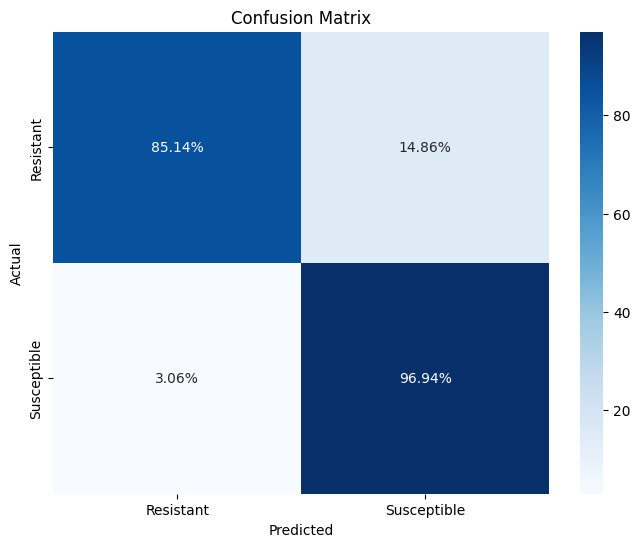

('              precision    recall  f1-score   support\n\n           0       0.89      0.85      0.87       276\n           1       0.96      0.97      0.96       915\n\n    accuracy                           0.94      1191\n   macro avg       0.92      0.91      0.92      1191\nweighted avg       0.94      0.94      0.94      1191\n',
 array([[235,  41],
        [ 28, 887]]))

In [13]:
evaluate_model(model, X_test_reshaped, y_test, threshold=0.5)
